# 🌞 MoonLight Energy Solutions: Solar Investment Analysis — Togo 🇹🇬

In [2]:
#all imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.append('../scripts')
import warnings
from scipy.stats import zscore
from data_quality_utils import columns_with_significant_missing_values,detect_outliers_zscore,find_columns_with_invalid_values, conditional_impute,impute_multiple_targets_with_model,impute_ghi_with_linear_regression,replace_negative_irradiance_with_nan,get_outlier_counts
from visualization_utils import plot_continuous_histograms, plot_scatter_relationships,plot_rh_relationships,plot_bubble_ghi_vs_tamb,plot_mod_cleaning_effect,plot_irradiance_temperature_timeseries,plot_hourly_irradiance_temperature, plot_monthly_irradiance_temperature,plot_ghi_anomalies,plot_wind_rose,plot_correlation_heatmap,plot_pairplot,plot_outlier_stripplots,plot_outlier_boxplots,filter_daytime
from feature_engineering_utils import log_transform_columns
from windrose import WindroseAxes

In [3]:
#suppress all warnings
warnings.filterwarnings("ignore")

## 📚 Table of Contents

1. [📊 Introduction & Objective](#1-introduction--objective)
2. [📦 Data Loading & Overview](#2-data-loading--overview)
3. [📐 Data Types & Basic Stats](#3-data-types--basic-stats)
4. [🔍 Data Quality Analysis](#4-data-quality-analysis)
5. [🧹 Data Cleaning](#5-data-cleaning)
6. [📈 Univariate Analysis (Single Variable)](#6-univariate-analysis-single-variable)
7. [📉 Bivariate/Multivariate Analysis](#7-bivariatemultivariate-analysis)
8. [🧮 Feature Engineering](#8-feature-engineering)
9. [📅 Time Series Trends](#9-time-series-trends)
10. [🧠 Key Insights](#10-key-insights)
11. [🔚 Conclusion & Next Steps](#11-conclusion--next-steps)

## 📊 1. Introduction & Objective <a id='#1-introduction--objective'></a>

### Background in the Subject Matter

Understanding lead and lag measures is crucial in solar energy analytics to identify what drives performance (lead) and what reflects performance outcomes (lag).

---

#### 🔹 Lead Measures

| Parameter         | Description |
|------------------|-------------|
| **Cleaning (1/0)** | Indicates whether a cleaning event occurred. A direct action that can influence panel efficiency. |
| **Precipitation (mm/min)** | Natural cleaning mechanism. Affects panel cleanliness and performance. |
| **RH (Relative Humidity)** | Can contribute to soiling or panel fogging. A predictive factor for efficiency. |
| **WS (Wind Speed)** | Can help remove dust/debris. High wind may act as a natural cleaning factor. |
| **TModA / TModB (°C)** | Module temperatures. Impact the conversion efficiency — monitored to optimize performance. |



#### 🔹 Lag Measures

| Parameter         | Description |
|------------------|-------------|
| **GHI (Global Horizontal Irradiance)** | Total solar radiation on a horizontal surface — reflects solar availability. |
| **DNI (Direct Normal Irradiance)** | Direct solar radiation received perpendicularly — outcome of atmospheric conditions. |
| **DHI (Diffuse Horizontal Irradiance)** | Scattered sunlight received — indicates sky clarity. |
| **ModA / ModB (W/m²)** | Actual power received by panels — outcome of environmental and maintenance factors. |
| **Tamb (Ambient Temperature)** | Environmental factor — affects efficiency but cannot be controlled. |
| **BP (Barometric Pressure)** | Reflects atmospheric conditions — no direct control. |
| **WD / WDstdev** | Wind direction and its variability — background environmental effects. |
| **WSstdev / WSgust** | Wind variability and gusts — lag indicators of natural impacts. |



###  🇹🇬 Background on Togo

#### ☀️ Solar Power Potential of Togo
Togo, located in West Africa between latitudes 6° and 11° North of the Equator, possesses considerable untapped solar energy potential. With average Global Horizontal Irradiance (GHI) levels ranging from 4.5 to 5.8 kWh/m²/day, the country enjoys consistent and abundant sunlight year-round. This makes Togo particularly well-suited for solar photovoltaic (PV) energy generation, especially in rural and off-grid areas where access to electricity remains limited. Its geographical position, combined with varied terrain and rising energy needs, positions Togo as a strategic location for scalable solar energy investments. 

### 🎯 Business Objective

- Perform a quick yet insightful analysis of solar radiation and environmental data to:
- Identify **key trends and performance drivers**.
- Understand the **impact of environmental conditions** on solar energy potential.
- Evaluate the **effect of soiling and cleaning** on solar module performance.
- Recommend **ideal conditions or locations** for sustainable solar installations.


### 🧠 Key Questions to Explore

1. **Solar Potential**  
   - Where and when is solar radiation (`GHI`, `DNI`, `DHI`) strongest and most consistent?

2. **Environmental Impact on Performance**  
   - How do temperature, humidity, wind, and pressure affect solar metrics?

3. **Sensor/Module Performance**  
   - How do `ModA` and `ModB` correlate with irradiance data?
   - Are performance improvements observed after cleaning?

4. **Cleaning Effectiveness**  
   - What is the impact of cleaning events on solar performance?
   - Can a cleaning schedule be recommended?

## 📦 2. Data Loading & Overview  <a id= '2-data-loading--overview'></a>

#### Loading Data

In [4]:
#load the data from the github repo or #using locally stored dataset
df=pd.read_csv('../data/togo-dapaong_qc.csv')
df

Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0       2021-10-25 00:01 -1.3  0.0  0.0   0.0   0.0  24.8  94.5  0.9     1.1   
1       2021-10-25 00:02 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.1     1.6   
2       2021-10-25 00:03 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.2     1.4   
3       2021-10-25 00:04 -1.2  0.0  0.0   0.0   0.0  24.8  94.3  1.2     1.6   
4       2021-10-25 00:05 -1.2  0.0  0.0   0.0   0.0  24.8  94.0  1.3     1.6   
...                  ...  ...  ...  ...   ...   ...   ...   ...  ...     ...   
525595  2022-10-24 23:56 -0.8  0.0  0.0   0.0   0.0  25.2  53.8  0.0     0.0   
525596  2022-10-24 23:57 -0.9  0.0  0.0   0.0   0.0  25.3  53.5  0.0     0.0   
525597  2022-10-24 23:58 -1.0  0.0  0.0   0.0   0.0  25.3  53.4  0.0     0.0   
525598  2022-10-24 23:59 -1.1  0.0  0.0   0.0   0.0  25.4  53.5  0.0     0.0   
525599  2022-10-25 00:00 -1.2  0.0  0.0   0.0   0.0  25.4  52.3  0.0     0.0   

        WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  TModA  TModB  \
0           0.4  227.6      1.1  977         0            0.0   24.7   24.4   
1           0.4  229.3      0.7  977         0            0.0   24.7   24.4   
2           0.3  228.5      2.9  977         0            0.0   24.7   24.4   
3           0.3  229.1      4.6  977         0            0.0   24.7   24.4   
4           0.4  227.5      1.6  977         0            0.0   24.7   24.4   
...         ...    ...      ...  ...       ...            ...    ...    ...   
525595      0.0    0.0      0.0  977         0            0.0   24.3   24.0   
525596      0.0    0.0      0.0  977         0            0.0   24.3   24.0   
525597      0.0    0.0      0.0  977         0            0.0   24.2   23.9   
525598      0.0    0.0      0.0  977         0            0.0   24.1   23.8   
525599      0.0    0.0      0.0  977         0            0.0   24.1   23.8   

        Comments  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
...          ...  
525595       NaN  
525596       NaN  
525597       NaN  
525598       NaN  
525599       NaN  

[525600 rows x 19 columns]

#### Data Overview

In [5]:
df.head()

Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0  2021-10-25 00:01 -1.3  0.0  0.0   0.0   0.0  24.8  94.5  0.9     1.1   
1  2021-10-25 00:02 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.1     1.6   
2  2021-10-25 00:03 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.2     1.4   
3  2021-10-25 00:04 -1.2  0.0  0.0   0.0   0.0  24.8  94.3  1.2     1.6   
4  2021-10-25 00:05 -1.2  0.0  0.0   0.0   0.0  24.8  94.0  1.3     1.6   

   WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  TModA  TModB  \
0      0.4  227.6      1.1  977         0            0.0   24.7   24.4   
1      0.4  229.3      0.7  977         0            0.0   24.7   24.4   
2      0.3  228.5      2.9  977         0            0.0   24.7   24.4   
3      0.3  229.1      4.6  977         0            0.0   24.7   24.4   
4      0.4  227.5      1.6  977         0            0.0   24.7   24.4   

   Comments  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN

In [6]:
df.tail()

Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
525595  2022-10-24 23:56 -0.8  0.0  0.0   0.0   0.0  25.2  53.8  0.0     0.0   
525596  2022-10-24 23:57 -0.9  0.0  0.0   0.0   0.0  25.3  53.5  0.0     0.0   
525597  2022-10-24 23:58 -1.0  0.0  0.0   0.0   0.0  25.3  53.4  0.0     0.0   
525598  2022-10-24 23:59 -1.1  0.0  0.0   0.0   0.0  25.4  53.5  0.0     0.0   
525599  2022-10-25 00:00 -1.2  0.0  0.0   0.0   0.0  25.4  52.3  0.0     0.0   

        WSstdev   WD  WDstdev   BP  Cleaning  Precipitation  TModA  TModB  \
525595      0.0  0.0      0.0  977         0            0.0   24.3   24.0   
525596      0.0  0.0      0.0  977         0            0.0   24.3   24.0   
525597      0.0  0.0      0.0  977         0            0.0   24.2   23.9   
525598      0.0  0.0      0.0  977         0            0.0   24.1   23.8   
525599      0.0  0.0      0.0  977         0            0.0   24.1   23.8   

        Comments  
525595       NaN  
525596       NaN  
525597       NaN  
525598       NaN  
525599       NaN

In [7]:
df.sample(10)

Timestamp    GHI    DNI    DHI   ModA   ModB  Tamb    RH   WS  \
35483   2021-11-18 15:24  413.5  600.9  120.3  442.8  432.1  36.4  16.4  2.3   
396918  2022-07-27 15:19  610.9  256.8  413.1  546.2  539.7  28.2  74.1  3.5   
437573  2022-08-24 20:54   -2.0    0.0    0.0    0.0    0.0  24.3  91.0  1.5   
297295  2022-05-19 10:56  991.0  561.4  425.7  886.0  874.0  33.1  56.2  3.6   
16533   2021-11-05 11:34  882.0  709.2  251.1  929.4  886.0  32.7  53.5  1.6   
427818  2022-08-18 02:19   -1.3    0.0    0.0    0.0    0.0  23.8  89.0  1.2   
354083  2022-06-27 21:24   -2.1    0.0    0.0    0.0    0.0  28.9  71.3  0.5   
312810  2022-05-30 05:31    1.6    0.0    1.8    3.1    2.9  26.7  81.2  0.7   
37808   2021-11-20 06:09   13.1    9.6   12.3   15.0   14.4  20.5  48.8  1.6   
65468   2021-12-09 11:09  858.0  694.2  283.3  937.7  898.0  31.2  15.8  3.9   

        WSgust  WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  TModA  \
35483      3.0      0.5   50.9     16.8  973         0            0.0   43.3   
396918     4.9      1.0  250.9     11.7  975         0            0.0   40.9   
437573     1.9      0.5  220.2      6.1  980         0            0.0   23.4   
297295     5.2      1.0  233.5     14.7  975         0            0.0   51.1   
16533      2.1      0.4  313.9      7.6  976         0            0.0   58.3   
427818     1.6      0.4  230.5     10.7  976         0            0.0   23.0   
354083     1.1      0.5  236.3      5.1  978         0            0.0   27.9   
312810     1.4      0.5  230.2     10.4  975         0            0.0   26.0   
37808      1.9      0.3  167.0      0.7  976         0            0.0   17.9   
65468      5.0      0.8   83.3     12.9  977         0            0.0   43.6   

        TModB  Comments  
35483    43.9       NaN  
396918   40.6       NaN  
437573   23.0       NaN  
297295   60.1       NaN  
16533    64.0       NaN  
427818   22.6       NaN  
354083   27.5       NaN  
312810   25.6       NaN  
37808    17.8       NaN  
65468    48.4       NaN

In [8]:
#shape of the dataset
df.shape

(525600, 19)

In [9]:
#list of columns of the dataset
df.columns

Index(['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS',
       'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation',
       'TModA', 'TModB', 'Comments'],
      dtype='object')

## 📐 3. Data Types & Basic Stats <a id='3-data-types--basic-stats'></a>

#### Data Summaries - basics stats

In [10]:
#Numerical Columns
df.describe().T

count        mean         std    min    25%    50%      75%  \
GHI            525600.0  230.555040  322.532347  -12.7   -2.2    2.1  442.400   
DNI            525600.0  151.258469  250.956962    0.0    0.0    0.0  246.400   
DHI            525600.0  116.444352  156.520714    0.0    0.0    2.5  215.700   
ModA           525600.0  226.144375  317.346938    0.0    0.0    4.4  422.525   
ModB           525600.0  219.568588  307.932510    0.0    0.0    4.3  411.000   
Tamb           525600.0   27.751788    4.758023   14.9   24.2   27.2   31.100   
RH             525600.0   55.013160   28.778732    3.3   26.5   59.3   80.800   
WS             525600.0    2.368093    1.462668    0.0    1.4    2.2    3.200   
WSgust         525600.0    3.229490    1.882565    0.0    1.9    2.9    4.400   
WSstdev        525600.0    0.557740    0.268923    0.0    0.4    0.5    0.700   
WD             525600.0  161.741845   91.877217    0.0   74.8  199.1  233.500   
WDstdev        525600.0   10.559568    5.915490    0.0    6.9   10.8   14.100   
BP             525600.0  975.915242    2.153977  968.0  975.0  976.0  977.000   
Cleaning       525600.0    0.000535    0.023116    0.0    0.0    0.0    0.000   
Precipitation  525600.0    0.001382    0.026350    0.0    0.0    0.0    0.000   
TModA          525600.0   32.444403   10.998334   13.1   23.9   28.4   40.600   
TModB          525600.0   33.543330   12.769277   13.1   23.6   28.4   43.000   
Comments            0.0         NaN         NaN    NaN    NaN    NaN      NaN   

                  max  
GHI            1424.0  
DNI            1004.5  
DHI             805.7  
ModA           1380.0  
ModB           1367.0  
Tamb             41.4  
RH               99.8  
WS               16.1  
WSgust           23.1  
WSstdev           4.7  
WD              360.0  
WDstdev          86.9  
BP              983.0  
Cleaning          1.0  
Precipitation     2.3  
TModA            70.4  
TModB            94.6  
Comments          NaN

In [11]:
#for columns of object type
df.describe(include=['O']).T

count  unique               top freq
Timestamp  525600  525600  2022-10-24 23:44    1

#### Data Types

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      525600 non-null  object 
 1   GHI            525600 non-null  float64
 2   DNI            525600 non-null  float64
 3   DHI            525600 non-null  float64
 4   ModA           525600 non-null  float64
 5   ModB           525600 non-null  float64
 6   Tamb           525600 non-null  float64
 7   RH             525600 non-null  float64
 8   WS             525600 non-null  float64
 9   WSgust         525600 non-null  float64
 10  WSstdev        525600 non-null  float64
 11  WD             525600 non-null  float64
 12  WDstdev        525600 non-null  float64
 13  BP             525600 non-null  int64  
 14  Cleaning       525600 non-null  int64  
 15  Precipitation  525600 non-null  float64
 16  TModA          525600 non-null  float64
 17  TModB          525600 non-nul

### Distinct Values

In [13]:
df.nunique().sort_values(ascending=False)

Timestamp        525600
ModA              10672
DNI                9612
GHI                8633
ModB               8439
DHI                6841
WD                 3601
RH                  966
TModB               769
WDstdev             614
TModA               564
Tamb                266
WSgust              156
WS                  143
WSstdev              44
Precipitation        22
BP                   16
Cleaning              2
Comments              0
dtype: int64

## 🔍 4. Data Quality Analysis <a id='4-data-quality-analysis'></a>

### Missing-Values Analysis

In [14]:
#count of missing values per column
df.isna().sum() 

Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64

##### Columns with significant number of missing values

In [15]:
#column with >5% nulls
columns_with_significant_missing_values(df, threshold=5)

#missing_values percentage
Comments           525600    100.00%

### Duplicated Values Analysis

In [16]:
#check for duplicates
print(df.duplicated().sum())

0


### Detect Invalid Data

#### Check if data lies within the valid range

In [17]:
# Dictionary of variable name and valid range (min, max)
valid_ranges = {
    'GHI': (0, 1300),
    'DNI': (0, 1300),
    'DHI': (0, 1000),
    'ModA': (0, 1300),
    'ModB': (0, 1300),
    'Tamb': (-40, 60),
    'TModA': (-40, 80),
    'TModB': (-40, 80),
    'RH': (0, 100),
    'WS': (0, 60),
    'WSgust': (0, 80),
    'WSstdev': (0, 20),
    'WD': (0, 360),
    'WDstdev': (0, 180),
    'BP': (800, 1100),
    'Precipitation': (0, 10),
    'Cleaning': (0, 1)
}


In [18]:
# Find columns that violate the valid ranges
find_columns_with_invalid_values(df,valid_ranges)

{'GHI': ['< 0', '> 1300'],
 'ModA': ['> 1300'],
 'ModB': ['> 1300'],
 'TModB': ['> 80']}

##### Looking into Negative Irradiance values

In [19]:
# Count rows where any of the three values is negative
invalid_rows = df[(df['GHI'] < 0) | (df['DHI'] < 0) | (df['DNI'] < 0)]

# Print count
print(f"Rows with at least one invalid irradiance value (GHI, DHI, or DNI < 0): {len(invalid_rows)}")


Rows with at least one invalid irradiance value (GHI, DHI, or DNI < 0): 257385


##### Check if these negative values for GHI,DNI and DHI occur simultaneously

In [20]:
# Create a boolean mask for each condition
neg_ghi = df['GHI'] < 0
neg_dhi = df['DHI'] < 0
neg_dni = df['DNI'] < 0

# Create a new column to capture the combination as a label
df['irradiance_negative_combo'] = (
    neg_ghi.astype(int).astype(str) + 
    neg_dhi.astype(int).astype(str) + 
    neg_dni.astype(int).astype(str)
)

# Count frequency of each combination
combo_counts = df['irradiance_negative_combo'].value_counts().sort_index()
print(combo_counts)


irradiance_negative_combo
000    268215
100    257385
Name: count, dtype: int64


##### Check if this negative values are recorded during the night -- to see if we can impute 0 as their value

In [21]:
#add hour and is_night columns to help with analysis
df['hour'] = pd.to_datetime(df['Timestamp']).dt.hour
df['is_night'] = (df['hour'] < 6) | (df['hour'] > 18)  # Example: night before 6 AM or after 6 PM
df


Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0       2021-10-25 00:01 -1.3  0.0  0.0   0.0   0.0  24.8  94.5  0.9     1.1   
1       2021-10-25 00:02 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.1     1.6   
2       2021-10-25 00:03 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.2     1.4   
3       2021-10-25 00:04 -1.2  0.0  0.0   0.0   0.0  24.8  94.3  1.2     1.6   
4       2021-10-25 00:05 -1.2  0.0  0.0   0.0   0.0  24.8  94.0  1.3     1.6   
...                  ...  ...  ...  ...   ...   ...   ...   ...  ...     ...   
525595  2022-10-24 23:56 -0.8  0.0  0.0   0.0   0.0  25.2  53.8  0.0     0.0   
525596  2022-10-24 23:57 -0.9  0.0  0.0   0.0   0.0  25.3  53.5  0.0     0.0   
525597  2022-10-24 23:58 -1.0  0.0  0.0   0.0   0.0  25.3  53.4  0.0     0.0   
525598  2022-10-24 23:59 -1.1  0.0  0.0   0.0   0.0  25.4  53.5  0.0     0.0   
525599  2022-10-25 00:00 -1.2  0.0  0.0   0.0   0.0  25.4  52.3  0.0     0.0   

        ...  WDstdev   BP  Cleaning  Precipitation  TModA  TModB  Comments  \
0       ...      1.1  977         0            0.0   24.7   24.4       NaN   
1       ...      0.7  977         0            0.0   24.7   24.4       NaN   
2       ...      2.9  977         0            0.0   24.7   24.4       NaN   
3       ...      4.6  977         0            0.0   24.7   24.4       NaN   
4       ...      1.6  977         0            0.0   24.7   24.4       NaN   
...     ...      ...  ...       ...            ...    ...    ...       ...   
525595  ...      0.0  977         0            0.0   24.3   24.0       NaN   
525596  ...      0.0  977         0            0.0   24.3   24.0       NaN   
525597  ...      0.0  977         0            0.0   24.2   23.9       NaN   
525598  ...      0.0  977         0            0.0   24.1   23.8       NaN   
525599  ...      0.0  977         0            0.0   24.1   23.8       NaN   

        irradiance_negative_combo  hour is_night  
0                             100     0     True  
1                             100     0     True  
2                             100     0     True  
3                             100     0     True  
4                             100     0     True  
...                           ...   ...      ...  
525595                        100    23     True  
525596                        100    23     True  
525597                        100    23     True  
525598                        100    23     True  
525599                        100     0     True  

[525600 rows x 22 columns]

In [22]:
# Filter rows where GHI, DNI, DHI < 0
irradiance_neg = df[(df['GHI'] < 0) | (df['DNI'] < 0) | (df['DHI'] < 0)]

# Check how many of those rows occurred at night
irradiance_neg['is_night'].value_counts()


is_night
True     235367
False     22018
Name: count, dtype: int64

##### Negative GHI,DNI,DHI values happening simaltaneously during the night - > candidates to be imputed as zero

In [23]:
# Group by combo and night/day
combo_night_counts = df.groupby(['irradiance_negative_combo', 'is_night']).size().unstack(fill_value=0)

# Rename columns for clarity
combo_night_counts.columns = ['day_count', 'night_count']  # False → Day, True → Night

# Optional: Add total count per combo
combo_night_counts['total'] = combo_night_counts['day_count'] + combo_night_counts['night_count']

# Display the result
print(combo_night_counts)


                           day_count  night_count   total
irradiance_negative_combo                                
000                           262682         5533  268215
100                            22018       235367  257385


<div style="border-radius:10px; border:orange solid; padding: 15px; font-size:100%; text-align:left; font-color:#325939;background-color:#2c2c2c">
<h3 align="left"><font color='orange'>💡 Course of Action:</font></h3>

We only have negative values for GHI - we can impute it from the module readings.

##### Exploring Irradiance values beyond 1300

In [24]:
# Filter rows where GHI or DNI are greater than 1300
high_irradiance_df = df[(df['GHI'] > 1300) | (df['ModA'] > 1300)| (df['ModB'] > 1300)]

# Display the filtered rows
print(high_irradiance_df)

# Optionally, see how many such rows exist
print(f"Number of rows with ModA or ModB> 1300: {len(high_irradiance_df)}")


               Timestamp     GHI    DNI    DHI    ModA    ModB  Tamb    RH  \
269959  2022-04-30 11:20  1301.0  733.9  562.1  1195.0  1178.0  31.0  54.5   
269962  2022-04-30 11:23  1306.0  757.1  548.0  1206.0  1189.0  31.3  53.0   
340531  2022-06-18 11:32  1391.0  688.6  699.0  1251.0  1236.0  26.5  80.5   
382441  2022-07-17 14:02  1328.0  829.3  592.9  1193.0  1183.0  26.3  82.5   
385171  2022-07-19 11:32  1304.0  754.4  547.3  1173.0  1158.0  28.5  70.1   
385172  2022-07-19 11:33  1367.0  823.7  550.9  1237.0  1222.0  28.4  70.1   
406818  2022-08-03 12:19  1385.0  826.2  550.5  1276.0  1262.0  28.2  72.2   
406834  2022-08-03 12:35  1325.0  780.6  531.0  1214.0  1200.0  29.0  70.2   
406846  2022-08-03 12:47  1320.0  716.3  589.4  1210.0  1198.0  29.2  68.9   
409719  2022-08-05 12:40  1324.0  722.8  604.5  1243.0  1230.0  27.9  71.5   
411122  2022-08-06 12:03  1362.0  797.1  548.6  1252.0  1242.0  28.7  65.5   
411174  2022-08-06 12:55  1301.0  802.1  498.7  1191.0  1181.0  

<div style="border-radius:10px; border:orange solid; padding: 15px; font-size:100%; text-align:left; font-color:#325939;background-color:#2c2c2c">
<h3 align="left"><font color='orange'>💡 Observations:</font></h3>
🔍 Observations: 

- These high GHI values mostly occur between 11:00 and 14:00, aligning with peak solar noon.

- High Direct Normal Irradiance (DNI) values (up to 861.8 W/m²) suggest clear-sky conditions with minimal cloud cover during those times.
</dv>



In [25]:
# Drop flags and timestamp columns
df.drop(columns=['irradiance_negative_combo', 'hour', 'is_night'], inplace=True)
df

Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0       2021-10-25 00:01 -1.3  0.0  0.0   0.0   0.0  24.8  94.5  0.9     1.1   
1       2021-10-25 00:02 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.1     1.6   
2       2021-10-25 00:03 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.2     1.4   
3       2021-10-25 00:04 -1.2  0.0  0.0   0.0   0.0  24.8  94.3  1.2     1.6   
4       2021-10-25 00:05 -1.2  0.0  0.0   0.0   0.0  24.8  94.0  1.3     1.6   
...                  ...  ...  ...  ...   ...   ...   ...   ...  ...     ...   
525595  2022-10-24 23:56 -0.8  0.0  0.0   0.0   0.0  25.2  53.8  0.0     0.0   
525596  2022-10-24 23:57 -0.9  0.0  0.0   0.0   0.0  25.3  53.5  0.0     0.0   
525597  2022-10-24 23:58 -1.0  0.0  0.0   0.0   0.0  25.3  53.4  0.0     0.0   
525598  2022-10-24 23:59 -1.1  0.0  0.0   0.0   0.0  25.4  53.5  0.0     0.0   
525599  2022-10-25 00:00 -1.2  0.0  0.0   0.0   0.0  25.4  52.3  0.0     0.0   

        WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  TModA  TModB  \
0           0.4  227.6      1.1  977         0            0.0   24.7   24.4   
1           0.4  229.3      0.7  977         0            0.0   24.7   24.4   
2           0.3  228.5      2.9  977         0            0.0   24.7   24.4   
3           0.3  229.1      4.6  977         0            0.0   24.7   24.4   
4           0.4  227.5      1.6  977         0            0.0   24.7   24.4   
...         ...    ...      ...  ...       ...            ...    ...    ...   
525595      0.0    0.0      0.0  977         0            0.0   24.3   24.0   
525596      0.0    0.0      0.0  977         0            0.0   24.3   24.0   
525597      0.0    0.0      0.0  977         0            0.0   24.2   23.9   
525598      0.0    0.0      0.0  977         0            0.0   24.1   23.8   
525599      0.0    0.0      0.0  977         0            0.0   24.1   23.8   

        Comments  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
...          ...  
525595       NaN  
525596       NaN  
525597       NaN  
525598       NaN  
525599       NaN  

[525600 rows x 19 columns]

### Outlier Detection

#### Detect outliers

In [26]:
columns_to_check_for_outliers = ['ModA','ModB','WS','WSgust','GHI','DHI','DNI']
outlier_df =(df, columns_to_check_for_outliers)
print(outlier_df)

(               Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0       2021-10-25 00:01 -1.3  0.0  0.0   0.0   0.0  24.8  94.5  0.9     1.1   
1       2021-10-25 00:02 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.1     1.6   
2       2021-10-25 00:03 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.2     1.4   
3       2021-10-25 00:04 -1.2  0.0  0.0   0.0   0.0  24.8  94.3  1.2     1.6   
4       2021-10-25 00:05 -1.2  0.0  0.0   0.0   0.0  24.8  94.0  1.3     1.6   
...                  ...  ...  ...  ...   ...   ...   ...   ...  ...     ...   
525595  2022-10-24 23:56 -0.8  0.0  0.0   0.0   0.0  25.2  53.8  0.0     0.0   
525596  2022-10-24 23:57 -0.9  0.0  0.0   0.0   0.0  25.3  53.5  0.0     0.0   
525597  2022-10-24 23:58 -1.0  0.0  0.0   0.0   0.0  25.3  53.4  0.0     0.0   
525598  2022-10-24 23:59 -1.1  0.0  0.0   0.0   0.0  25.4  53.5  0.0     0.0   
525599  2022-10-25 00:00 -1.2  0.0  0.0   0.0   0.0  25.4  52.3  0.0     0.0   

        WSstdev     WD  WDstdev   BP  

#### Visualize outliers

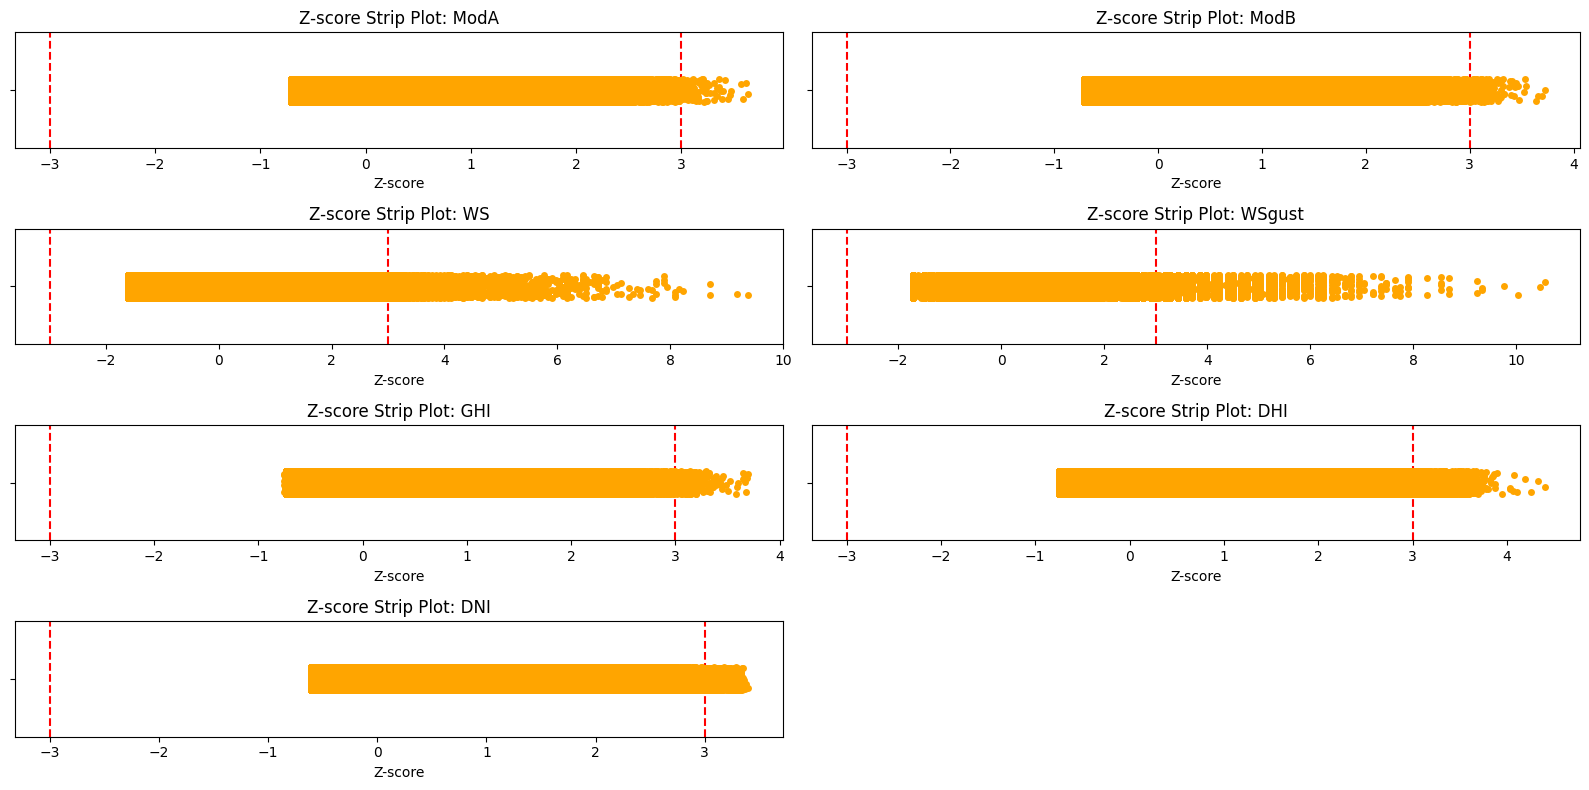

In [27]:
#Z-Score Outlier Strip Plot
plot_outlier_stripplots(df, columns_to_check_for_outliers)

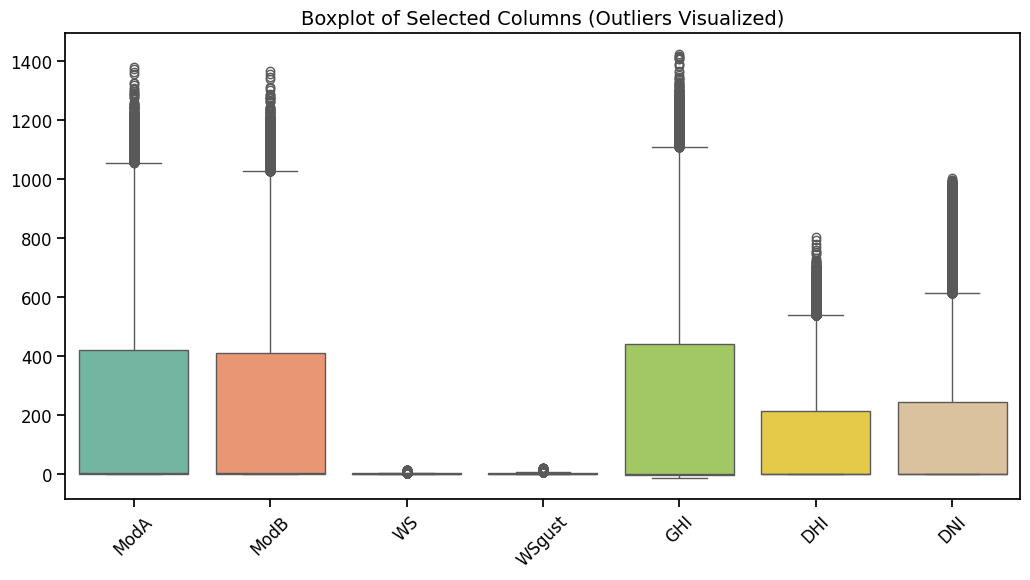

In [28]:

#Visualizing outliers using boxplots
plot_outlier_boxplots(df, columns_to_check_for_outliers)

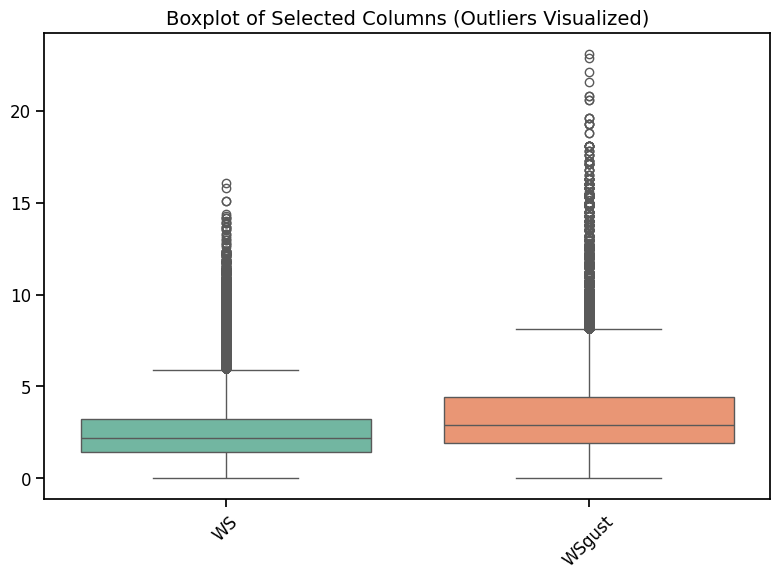

In [29]:
#Singling out WS and WSgust
plot_outlier_boxplots(df, columns_to_check_for_outliers[2:4])

## 🧹 5. Data Cleaning  <a id='5-data-cleaning'></a>

In [30]:
#saving the original dataset for later use
df_original=df.copy()

#### Handle Missing Values

In [31]:
# the comments columns doesn't have any value
columns_to_delete = ['Comments']
existing_columns = [col for col in columns_to_delete if col in df.columns]
df = df.drop(existing_columns, axis=1)

In [32]:
#inspect the data after dropping the columns
df.sample(10)

Timestamp    GHI    DNI    DHI   ModA   ModB  Tamb    RH   WS  \
172607  2022-02-21 20:48   -3.9    0.0    0.0    0.0    0.0  27.6  15.0  1.4   
228886  2022-04-01 22:47   -2.5    0.0    0.0    0.0    0.0  31.8  48.1  2.7   
519040  2022-10-20 10:41  867.0  563.0  327.6  900.1  871.0  31.6  60.1  1.9   
4139    2021-10-27 21:00   -1.9    0.0    0.0    0.0    0.0  27.2  72.8  2.3   
281390  2022-05-08 09:51  797.4  492.6  357.4  732.9  688.8  32.0  59.3  3.9   
514276  2022-10-17 03:17   -2.6    0.0    0.0    0.0    0.0  23.3  90.3  0.4   
243959  2022-04-12 10:00  212.6    0.0  219.2  209.3  204.6  25.3  83.4  3.1   
313851  2022-05-30 22:52   -0.8    0.0    0.0    0.0    0.0  21.4  87.4  4.4   
78842   2021-12-18 18:03   -4.4    0.0    0.0    0.0    0.0  27.9  21.5  2.2   
445588  2022-08-30 10:29  591.8   20.5  563.7  563.2  556.5  27.7  68.0  0.5   

        WSgust  WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  TModA  \
172607     2.1      0.4   59.5      7.4  977         0            0.0   25.7   
228886     3.4      0.5  240.6      8.6  974         0            0.0   31.2   
519040     2.6      0.5  202.8     27.1  977         0            0.0   58.5   
4139       2.9      0.4  219.7      6.5  977         0            0.0   26.5   
281390     5.7      0.7  213.8     10.4  976         0            0.0   49.5   
514276     0.7      0.5  244.1      0.7  976         0            0.0   21.3   
243959     3.9      0.6  236.1      9.6  976         0            0.0   31.4   
313851     5.7      0.8  319.5      8.3  977         0            0.0   21.5   
78842      2.6      0.4   47.9      6.4  976         0            0.0   26.8   
445588     1.1      0.5  348.0      3.6  978         0            0.0   40.0   

        TModB  
172607   25.3  
228886   30.9  
519040   65.7  
4139     26.1  
281390   60.4  
514276   21.1  
243959   33.5  
313851   21.2  
78842    26.7  
445588   45.9

### Handle Inconsistencies / Inaccuracies

#### Impute zero when all GHI,DHI and DNI are negative during the night

In [33]:
# Impute zero when all GHI,DHI and DNI are negative during the night
conditions = {
    'GHI': '<= 0',
    'DHI': '<= 0',
    'DNI': '<= 0',
    'is_night': '== True'
}

updates = {
    'GHI': 0,
    'DHI': 0,
    'DNI': 0
}
df = conditional_impute(df, 'Timestamp', conditions, updates)

In [34]:
df.sample(10)

Timestamp    GHI    DNI    DHI   ModA   ModB  Tamb    RH  \
299246 2022-05-20 19:27:00    0.0    0.0    0.0    0.0    0.0  33.2  47.0   
202601 2022-03-14 16:42:00  173.2    0.0  174.6  163.6  155.8  36.3  25.8   
337234 2022-06-16 04:35:00    0.0    0.0    0.0    0.0    0.0  24.0  89.9   
90271  2021-12-26 16:32:00  181.2  237.6  104.4  188.8  181.9  34.3  13.3   
358183 2022-06-30 17:44:00   22.6    0.0   22.2   23.4   23.3  23.9  87.8   
304549 2022-05-24 11:50:00  839.0  268.6  544.1  757.8  733.0  30.1  61.4   
323376 2022-06-06 13:37:00  565.7  179.6  362.4  478.4  474.6  31.2  59.2   
256943 2022-04-21 10:24:00  344.8    1.1  348.8  340.6  336.6  27.2  73.0   
289796 2022-05-14 05:57:00   16.6    0.0   16.8   16.7   16.5  25.1  77.0   
180372 2022-02-27 06:13:00   -0.2    0.0    1.6    3.2    3.0  23.6  17.2   

         WS  WSgust  WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  \
299246  3.1     4.9      0.8  152.0     15.2  975         0            0.0   
202601  3.4     4.1      0.5   62.3     10.2  971         0            0.0   
337234  2.2     2.9      0.5  220.1     14.0  975         0            0.0   
90271   4.4     5.0      0.5   59.1     15.1  974         0            0.0   
358183  2.4     3.4      0.7  233.4     11.1  976         0            0.0   
304549  4.8     6.9      0.9  302.4     14.3  978         0            0.0   
323376  3.4     4.8      0.8  230.6     19.4  976         0            0.0   
256943  2.6     4.1      0.8  218.0     13.2  976         0            0.0   
289796  2.0     3.1      0.7  158.9     15.8  975         0            0.0   
180372  2.6     3.1      0.4   87.9     10.1  975         0            0.0   

        TModA  TModB  
299246   32.6   32.3  
202601   40.1   40.2  
337234   24.0   23.7  
90271    36.5   36.4  
358183   24.9   24.7  
304549   54.6   63.6  
323376   51.4   53.0  
256943   35.1   39.0  
289796   25.3   25.1  
180372   22.8   22.3

In [35]:
#because of the near linear relationship between GHi and MdoA and ModB, we can use regression to impute the 
#negative values of GHI

#Lets set all negative values of GHI,DHI,DNI to NaN
df=replace_negative_irradiance_with_nan(df)
# Impute GHI using ModA and ModB
df =impute_ghi_with_linear_regression(df)
df.sample(10)

Timestamp    GHI    DNI    DHI   ModA   ModB  Tamb    RH  \
137550 2022-01-28 12:31:00  755.9  176.4  602.1  765.5  743.1  30.2  14.7   
153892 2022-02-08 20:53:00    0.0    0.0    0.0    0.0    0.0  26.2  14.7   
386372 2022-07-20 07:33:00  163.0    4.3  151.0  141.3  140.1  23.9  90.1   
81270  2021-12-20 10:31:00  760.9  493.9  375.1  828.3  790.2  26.0  23.2   
246071 2022-04-13 21:12:00    0.0    0.0    0.0    0.0    0.0  31.4  55.7   
500450 2022-10-07 12:51:00  389.7    0.0  387.7  381.6  378.7  29.4  70.1   
338082 2022-06-16 18:43:00    0.0    0.0    0.0    0.0    0.0  26.6  77.8   
367690 2022-07-07 08:11:00  430.4  386.5  194.0  343.7  338.8  27.5  74.5   
252925 2022-04-18 15:26:00  520.1  334.8  284.4  464.4  452.6  35.7  36.3   
388845 2022-07-22 00:46:00    0.0    0.0    0.0    0.0    0.0  25.7  81.3   

         WS  WSgust  WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  \
137550  2.5     4.1      1.2   61.2     19.7  977         0            0.0   
153892  1.2     1.9      0.4   25.5      3.1  977         0            0.0   
386372  2.4     3.4      0.6  197.4     14.9  978         0            0.0   
81270   5.4     7.4      1.1   79.7     11.9  980         0            0.0   
246071  3.3     5.2      0.7  209.1     16.7  972         0            0.0   
500450  0.7     1.6      0.7  171.5     13.4  976         0            0.0   
338082  2.3     3.1      0.8  203.7     13.1  975         0            0.0   
367690  3.4     4.4      0.6  254.7     10.2  979         0            0.0   
252925  3.1     4.1      0.6  193.8     15.4  972         0            0.0   
388845  1.0     1.6      0.4  244.6      4.1  976         0            0.0   

        TModA  TModB  
137550   46.1   48.0  
153892   23.0   23.0  
386372   29.7   30.4  
81270    36.0   41.6  
246071   31.2   30.8  
500450   43.8   46.8  
338082   27.1   26.8  
367690   41.4   43.7  
252925   48.4   49.0  
388845   25.0   24.7

In [36]:
#impute DNI and DHI using other features
# df=impute_multiple_targets_with_model(df)


In [37]:
df.sample(10)

Timestamp     GHI    DNI    DHI    ModA   ModB  Tamb    RH  \
428434 2022-08-18 12:35:00  1014.0  849.1  144.3   939.0  924.0  30.5  58.9   
222666 2022-03-28 15:07:00   550.3   95.1  470.4   510.1  456.3  39.2   6.7   
461570 2022-09-10 12:51:00   418.9    0.0  409.1   384.2  380.4  29.1  74.0   
285735 2022-05-11 10:16:00   875.0  667.9  244.3   787.5  765.5  34.1  51.9   
193383 2022-03-08 07:04:00   118.8   60.9  104.4   107.2  100.8  25.1  18.9   
30025  2021-11-14 20:26:00     0.0    0.0    0.0     0.0    0.0  28.8  47.3   
318951 2022-06-03 11:52:00  1115.0  741.8  365.0  1006.5  984.0  32.9  39.4   
469462 2022-09-16 00:23:00     0.0    0.0    0.0     0.0    0.0  22.0  97.9   
208862 2022-03-19 01:03:00     0.0    0.0    0.0     0.0    0.0  30.2  36.9   
362590 2022-07-03 19:11:00     0.0    0.0    0.0     0.0    0.0  27.6  74.9   

         WS  WSgust  WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  \
428434  3.2     3.9      0.5  306.7     13.7  977         0            0.0   
222666  1.3     2.4      0.7  108.7     17.5  974         0            0.0   
461570  2.8     3.9      0.6  224.0     13.3  978         0            0.0   
285735  4.9     5.9      0.7  238.0     15.8  976         0            0.0   
193383  1.5     1.9      0.5   50.0     13.1  973         0            0.0   
30025   1.8     2.4      0.4  162.9      8.7  976         0            0.0   
318951  4.8     5.7      0.8  196.4     18.6  975         0            0.0   
469462  2.4     3.6      0.7  280.7     10.2  978         0            0.1   
208862  0.0     0.0      0.0    0.0      0.0  973         0            0.0   
362590  1.9     2.6      0.5  217.3     11.0  977         0            0.0   

        TModA  TModB  
428434   54.5   56.8  
222666   49.1   49.1  
461570   43.9   47.0  
285735   53.9   59.6  
193383   28.6   29.5  
30025    26.6   26.5  
318951   54.2   60.2  
469462   22.4   22.1  
208862   29.3   29.1  
362590   26.9   26.5

In [38]:
#count of missing values per column
df.isna().sum() 

Timestamp        0
GHI              0
DNI              0
DHI              0
ModA             0
ModB             0
Tamb             0
RH               0
WS               0
WSgust           0
WSstdev          0
WD               0
WDstdev          0
BP               0
Cleaning         0
Precipitation    0
TModA            0
TModB            0
dtype: int64

## 📈 6. Univariate Analysis (Single Variable) <a id='Univariate Analysis (Single Variable)'></a>

### Distributions of Variables

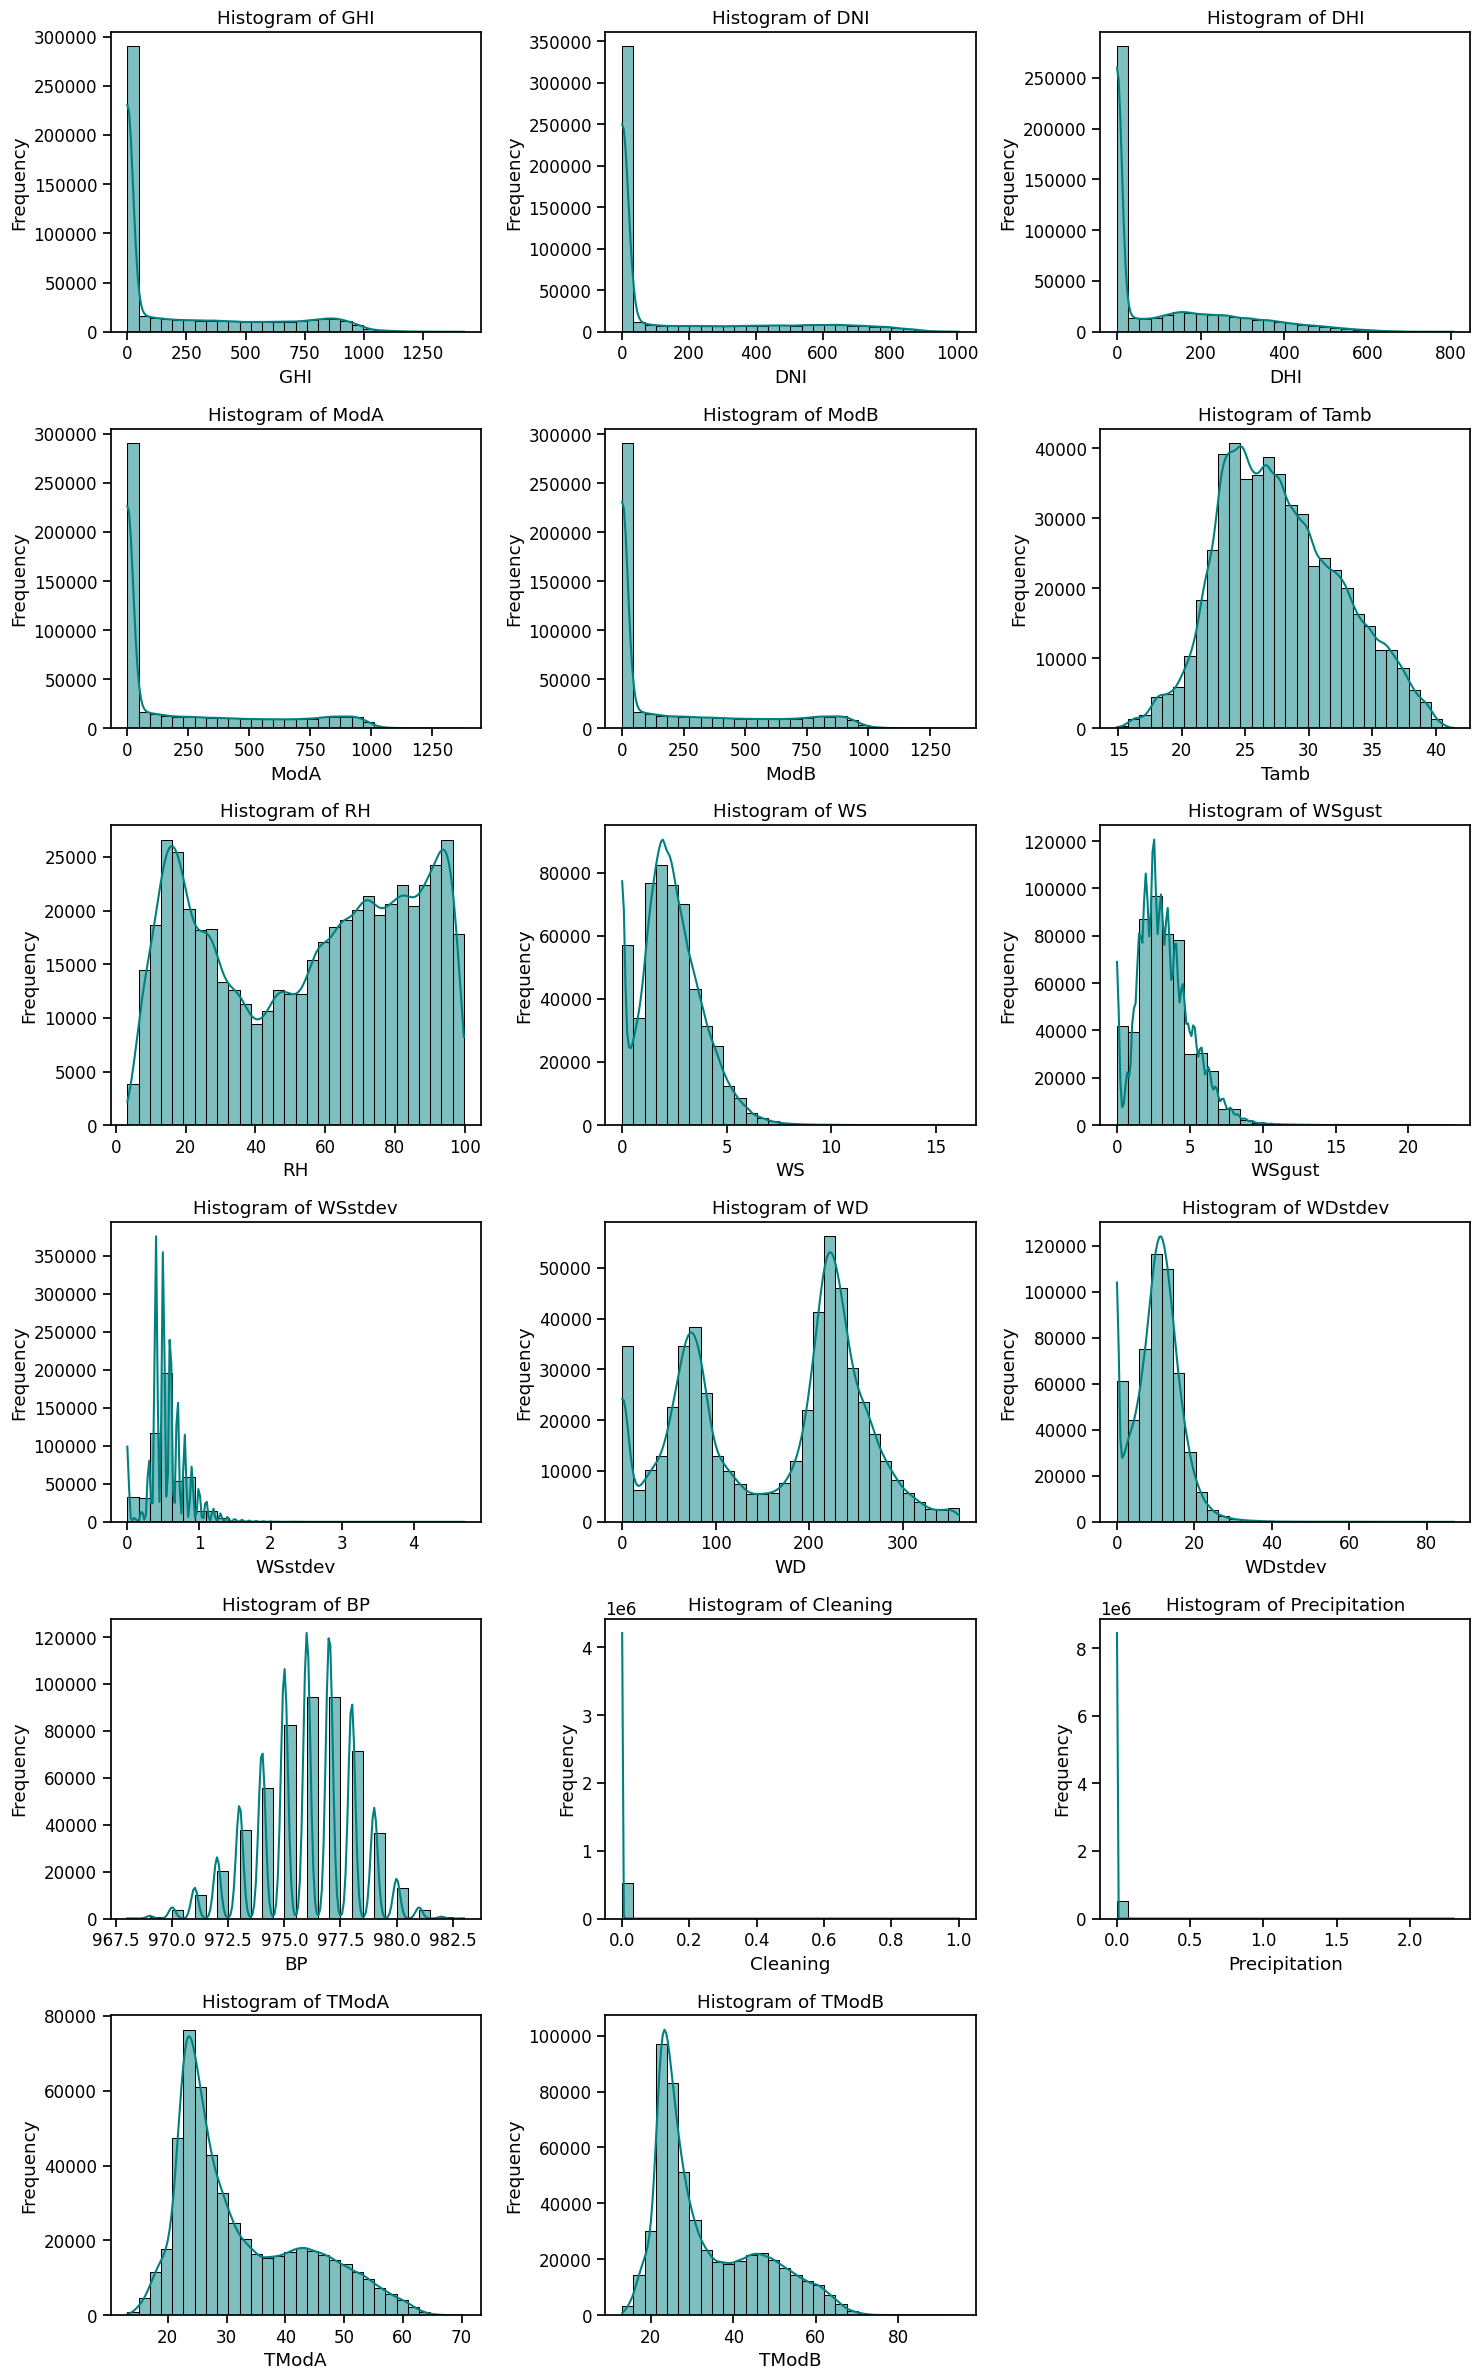

In [39]:
#plot histograms for continuous variables
plot_continuous_histograms(df)

## 📉 7. Bivariate/Multivariate Analysis <a id='7-bivariatemultivariate-analysis'>

### Correlation & Relationship Analysis

In [40]:
columns=df.columns.to_list()
columns

['Timestamp',
 'GHI',
 'DNI',
 'DHI',
 'ModA',
 'ModB',
 'Tamb',
 'RH',
 'WS',
 'WSgust',
 'WSstdev',
 'WD',
 'WDstdev',
 'BP',
 'Cleaning',
 'Precipitation',
 'TModA',
 'TModB']

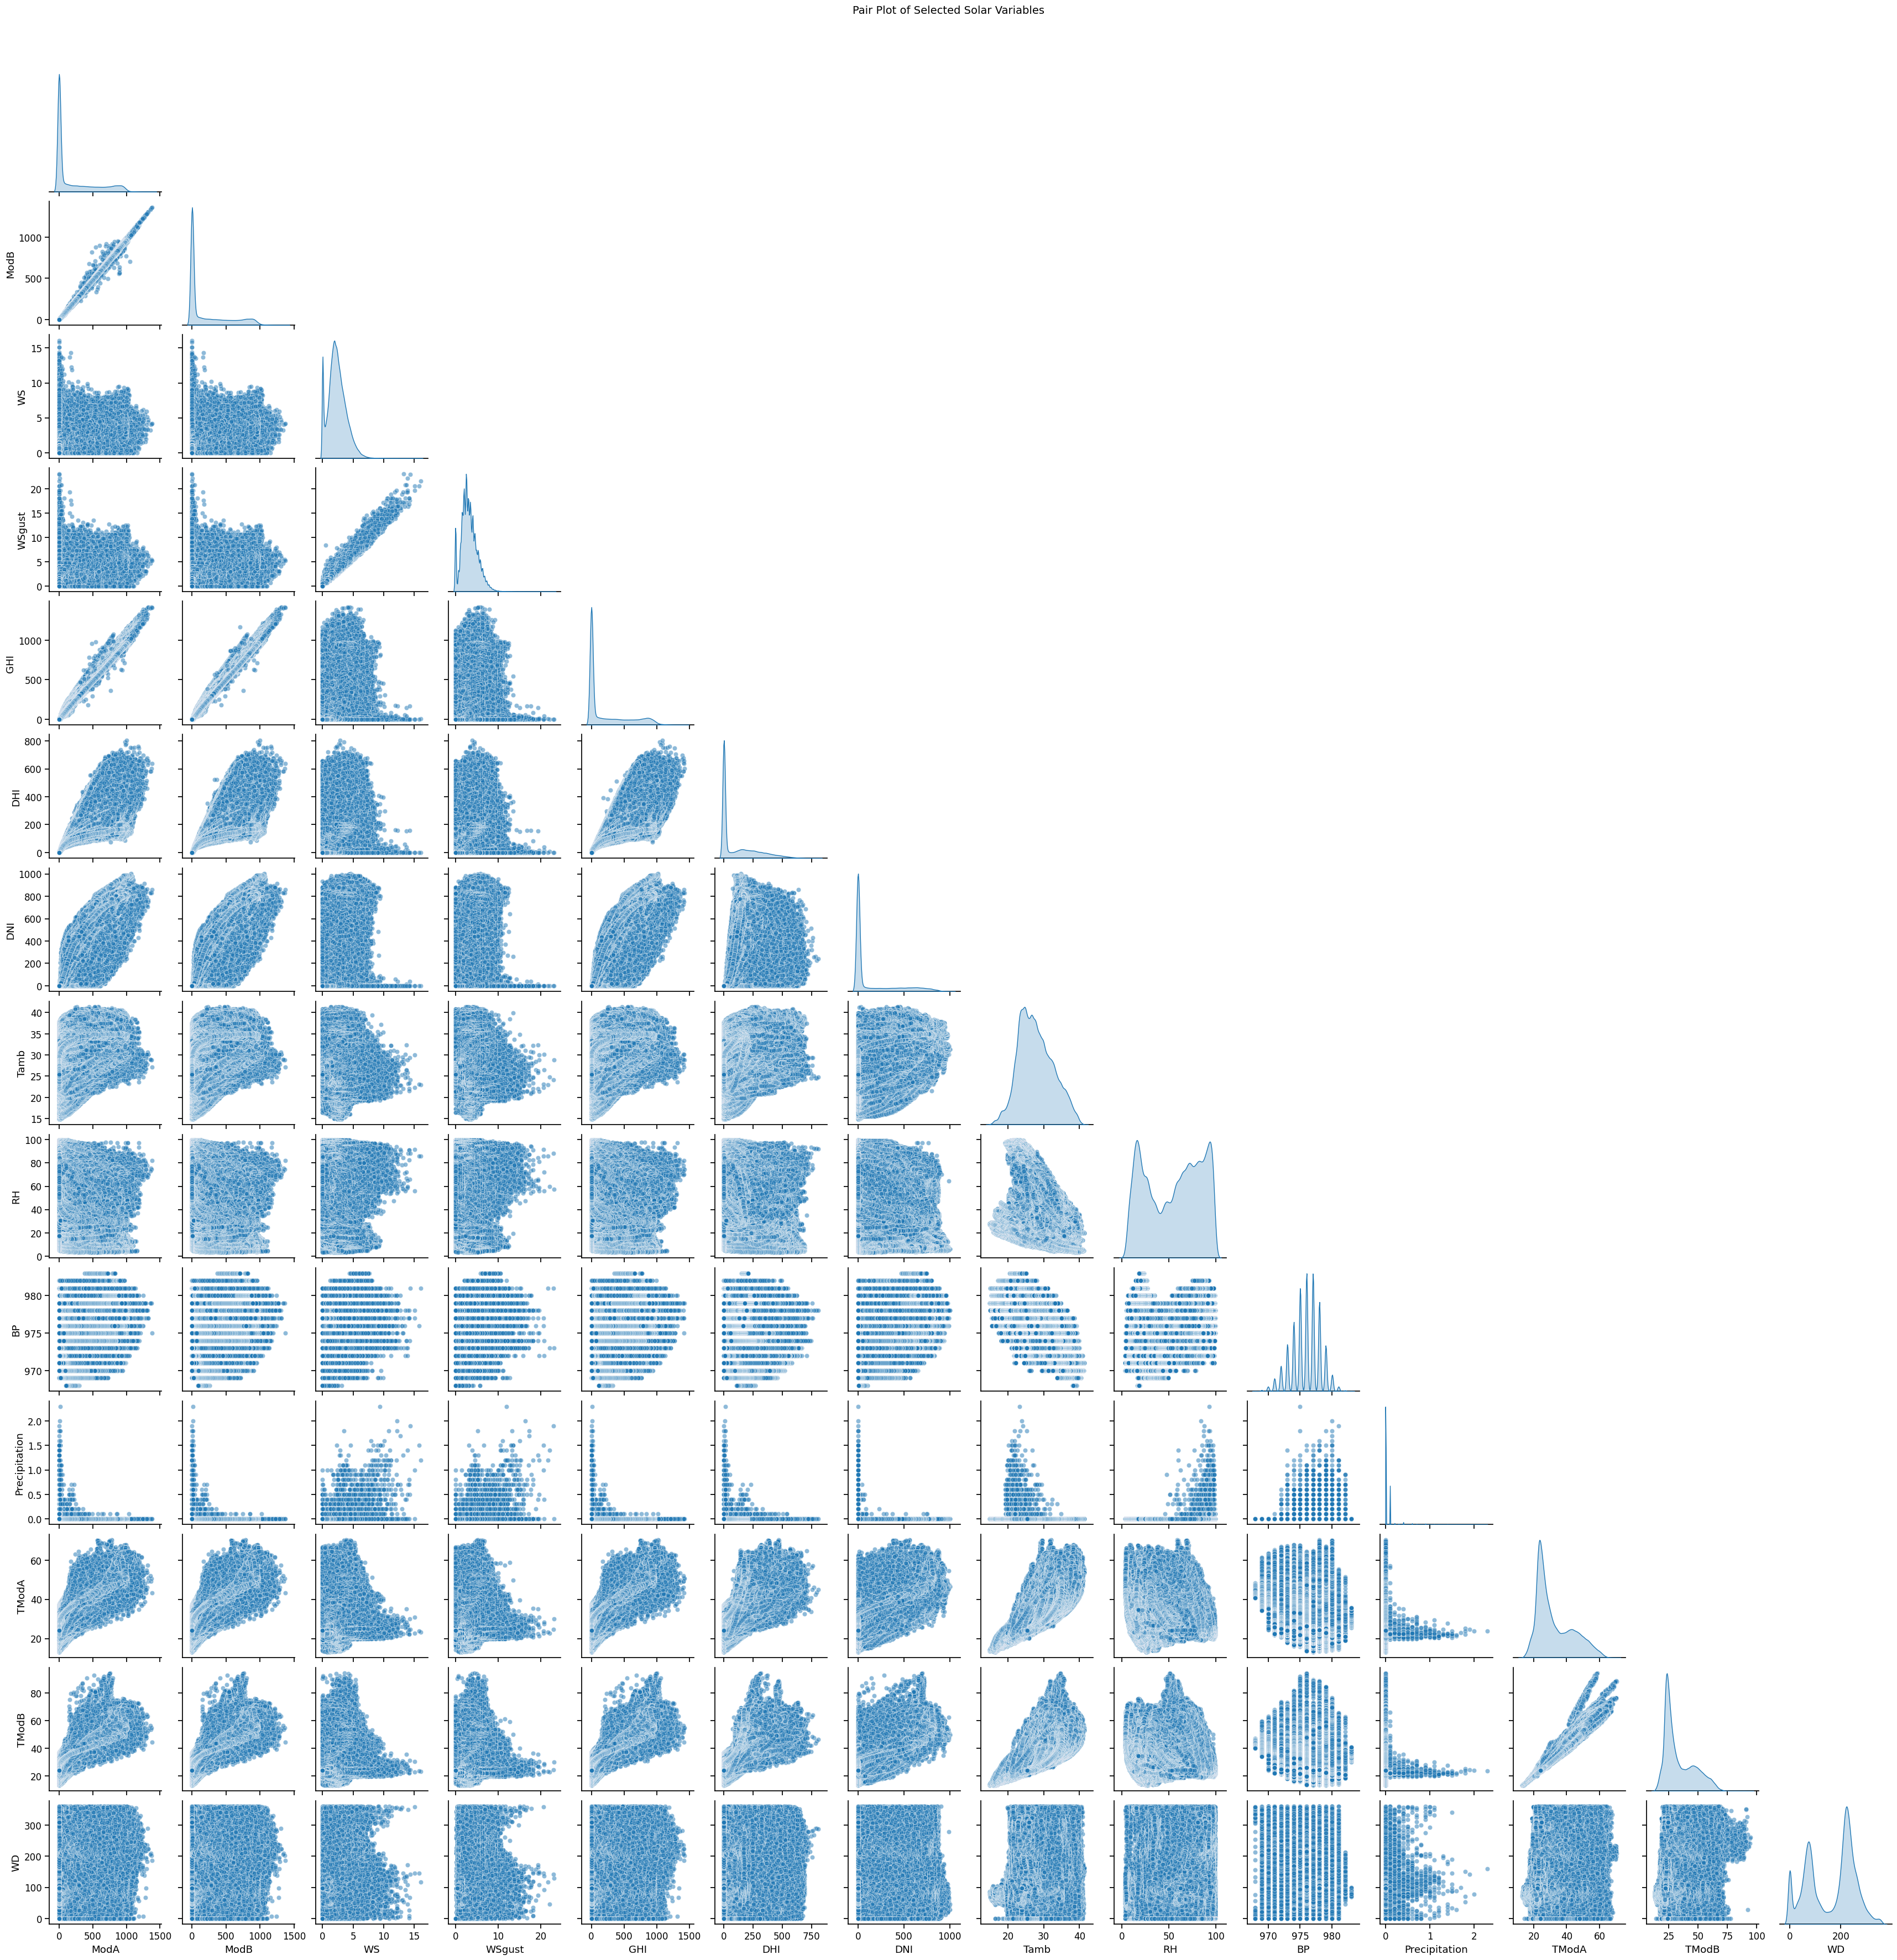

In [41]:
# Pairplot of selected columns
columns_for_pairplot = [*columns_to_check_for_outliers, 'Tamb', 'RH', 'BP', 'Precipitation', 'TModA', 'TModB', 'WD']
plot_pairplot(df, columns_for_pairplot)

#### Heatmap of correlations (GHI, DNI, DHI, TModA, TModB).

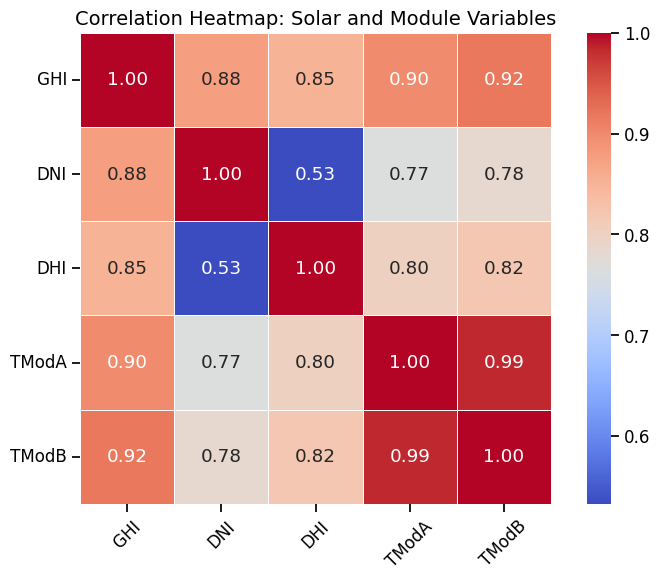

In [43]:
columns = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
plot_correlation_heatmap(df,columns)

#### Scatter plots: WS, WSgust, WD vs. GHI; RH vs. Tamb or RH vs. GHI.


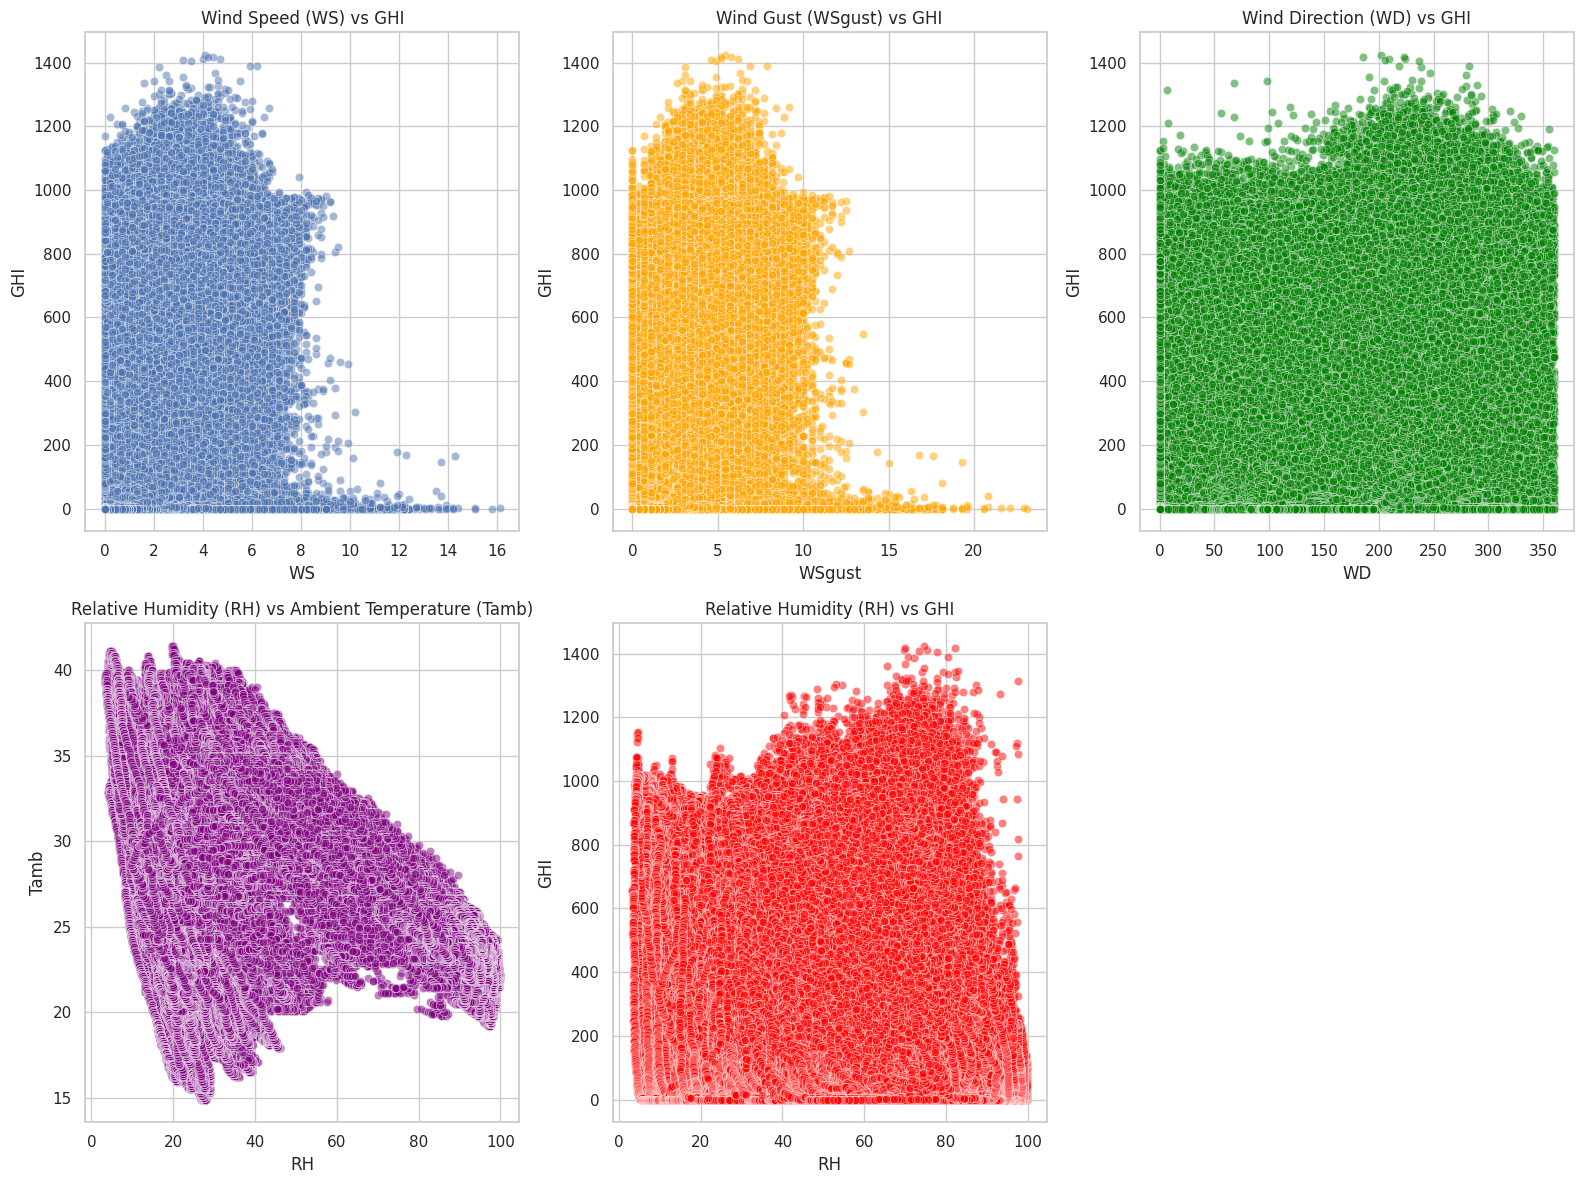

In [44]:
plot_scatter_relationships(df)

#### Wind & Distribution Analysis

In [ ]:
plot_wind_rose(df)

### Temperature Analysis

In [ ]:
#Examine how relative humidity (RH) might influence temperature readings and solar radiation
plot_rh_relationships(df)

#### Bubble Chart

In [ ]:
#GHI vs. Tamb with bubble size = RH or BP.
plot_bubble_ghi_vs_tamb(df)

### Cleaning Effect

In [ ]:
# Group by 'Cleaning' and calculate mean for ModA and ModB
plot_mod_cleaning_effect(df)

## 🧮 Feature Engineering <a id='8-feature-engineering'><a>

#### GHI,DNI,DHI,ModA and ModB  have skewed distribution - transforming them to normal distribution will help in case we choose to use parametric tests later

In [ ]:
#log transform the columns GHI, DNI, DHI, ModA and ModB
df=log_transform_columns(df, ['GHI', 'DNI', 'DHI', 'ModA', 'ModB'])

In [ ]:
# recheck the distributions after log transformation
plot_continuous_histograms(df)

## 📅 9. Time Series Trends  <a id='9-time-series-trends'></a>

#### Line or bar charts of GHI, DNI, DHI, Tamb vs. Timestamp.

In [ ]:
plot_irradiance_temperature_timeseries(df_original)

#### Observe patterns by month, trends throughout day, or anomalies, such as peaks in solar irradiance or temperature fluctuations. 

##### 🔍 1. Monthly Patterns

In [ ]:
# Extract month from timestamp
plot_monthly_irradiance_temperature(df_original)

#### 🕒 2. Daily Trends

In [ ]:
#plot average daily patter of irradiance and temperature by hour
plot_hourly_irradiance_temperature(df)

In [ ]:
#filter out daytime measurements
day_df=filter_daytime(df)

In [ ]:
#plot distribution of measurements for daytime data
plot_continuous_histograms(day_df)

##### ⚠️ 3. Anomaly Detection (Peaks & Drops)

In [ ]:
plot_ghi_anomalies(df)

#### Save the preprocessed dataset

In [ ]:
#### Save the preprocessed dataset
df.to_csv('../data/togo-dapaong', index=False)


## 🧠 10. Key Insights <a id='10-key-insights'></a>

<div style="border-radius:10px; border:orange solid; padding: 15px; font-size:100%; text-align:left; font-color:#325939;background-color:#2c2c2c">
<h3 align="left"><font color='orange'>💡 Observations:</font></h3>

* There is near-linear relationship between WS (Wind Speed) and WSgust (Wind Gust Speed): In the context of the project — analyzing solar energy potential and sensor performance — it might be redundant to include both WS (Wind Speed) and WSgust (Wind Gust)
* There is a near linear relationship between GHI and both ModA and ModB
* There is a near linear relationship between ModA and ModB
* WD has little correlation with any of the other variables
* There is a linear relationship between TModA and TModB and their correlation with all other variables is near identical
</div>

<div style="border-radius:10px; border:orange solid; padding: 15px; font-size:100%; text-align:left; font-color:#325939;background-color:#2c2c2c">
<h3 align="left"><font color='orange'>💡 Observations:</font></h3>

**☀️ Solar Irradiance Variables (GHI, DNI, DHI, ModA, ModB)**
Distributions are right-skewed: Most values are close to zero, with a long tail of high values.

**Implication:** These are only non-zero during daytime → confirms irradiance-based splitting logic (e.g., GHI > 0 → daytime).

**Action:** There might be a need to  apply log transformation or clipping when using them for modeling or visualization.
</div>

<div style="border-radius:10px; border:orange solid; padding: 15px; font-size:100%; text-align:left; font-color:#325939;background-color:#2c2c2c">
<h3 align="left"><font color='orange'>💡 Observations:</font></h3>

**💧 Humidity (RH)**
Fairly uniform or slightly U-shaped: High frequency at both low and high RH levels.

**Implication:** Reflects variability in atmospheric moisture (from dry to humid).

**Action:** RH can be a good input to model heat dissipation or fog effects on panels.
</div>

<div style="border-radius:10px; border:orange solid; padding: 15px; font-size:100%; text-align:left; font-color:#325939;background-color:#2c2c2c">
<h3 align="left"><font color='orange'>💡 Observations:</font></h3>

**🧪 BP (Barometric Pressure)**
Shows cyclical fluctuations (possibly measurement artifact or elevation-influenced).

**Implication:** Limited predictive power unless used in atmospheric modeling.

**Optional:** Could be dropped if irrelevant for power forecasting.
</div>

## 🔚 11. Conclusion & Next Steps <a id='11-conclusion--next-steps'></a>

<div style="border-radius:10px; border:orange solid; padding: 15px; font-size:100%; text-align:left; font-color:#325939;background-color:#2c2c2c">
<h3 align="left"><font color='orange'>💡 Recommendations:</font></h3>

* Given the strong correlations among solar variables (GHI, DNI, DHI, ModA, ModB), consider dimensionality reduction (e.g., PCA) or selecting a subset to avoid multicollinearity in modeling.
* Temperature and humidity variables are moderately correlated with solar irradiance, so including both can help models capture environmental conditions affecting your system.
* Log-transforming skewed variables like solar irradiance and wind speeds could improve model performance by normalizing their distributions.
* Variables like Cleaning and Precipitation are mostly zeros. Ensure models handle this class imbalance properly or use specialized techniques for rare events.
* Consider interaction terms between solar radiation and humidity or temperature, as their interplay may affect your system’s behavior.
</div>